# **Loading the dependencies**

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import models
from torchvision import transforms

# **GPU avail check**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Splitting CIFAR 10 data into training and test**

In [3]:
batch_size = 128
lr = 0.01
epoch = 20

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:07<00:00, 22.2MB/s]


# **A subset of input data**

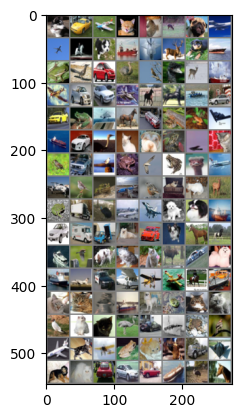

Train: dog   car   plane cat   cat   deer  dog   plane plane horse dog   ship  plane deer  dog   ship  frog  bird  car   bird  bird  bird  deer  ship  plane car   car   plane horse horse ship  car   car   frog  plane horse truck frog  frog  plane ship  car   bird  cat   dog   frog  plane cat   bird  car   bird  frog  bird  frog  bird  plane plane bird  frog  plane bird  cat   cat   deer  frog  truck bird  plane plane dog   dog   ship  car   truck truck dog   car   dog   horse horse ship  bird  dog   cat   cat   deer  car   dog   ship  plane car   plane plane plane horse ship  cat   cat   cat   ship  dog   frog  cat   cat   bird  cat   cat   bird  car   ship  frog  bird  plane cat   plane frog  cat   dog   truck plane dog   cat   car   car   car   ship  bird  horse


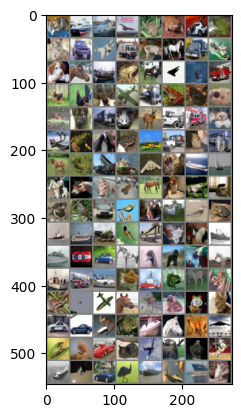

Test:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse deer  dog   frog  cat   car   car   cat   frog  ship  horse deer  plane frog  bird  car   cat   plane deer  bird  horse ship  cat   car   bird  ship  plane ship  cat  


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
imgs_tr, labls_tr = next(dataiter)
imshow(torchvision.utils.make_grid(imgs_tr))
print('Train:', ' '.join(f'{classes[labls_tr[j]]:5s}' for j in range(batch_size)))


imgs_te, labls_te = next(iter(testloader))
imshow(torchvision.utils.make_grid(imgs_te))
print('Test: ', ' '.join(f'{classes[labls_te[j]]:5s}' for j in range(batch_size)))

# **Loading the MobileNetV2 architecture**

In [5]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)

    def forward(self, x):
        return self.model(x)

# **Training MobiileNetV2 on CIFAR data**

In [6]:
num_classes = len(classes)
model = MobileNetV2(num_classes=num_classes).to(device)
imgs, _ = next(iter(trainloader))
summary(model, (imgs.shape[1], imgs.shape[2], imgs.shape[3]))
print(f'Number of classes: {num_classes}  ----------  Names of the classes: {classes}')

optimizer_model = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
thr = 100
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for j in tqdm(range(epoch)):
    tr_loss = 0
    correct_train = 0
    total_train = 0
    model.train()
    for images, labels in trainloader:
        optimizer_model.zero_grad()
        outputs = model(images.to(device))
        loss = loss_func(outputs, labels.to(device))
        loss.backward()
        optimizer_model.step()
        tr_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()
        if loss.data.cpu().numpy() < thr:
            torch.save(model.state_dict(), './trained_model_weights_mobilenetv2.pkl')
            thr = loss.data.cpu().numpy()
    training_loss.append(tr_loss / len(trainloader))
    training_accuracy.append(100 * correct_train / total_train)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images.to(device))
            loss = loss_func(outputs, labels.to(device))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels.to(device)).sum().item()
    validation_loss.append(val_loss / len(testloader))
    validation_accuracy.append(100 * correct_val / total_val)
    print(f"\nEpoch [{j+1}/{epoch}], Train Loss: {training_loss[-1]:.4f}, Val Loss: {validation_loss[-1]:.4f}, Train Acc: {training_accuracy[-1]:.2f}%, Val Acc: {validation_accuracy[-1]:.2f}%")

training_loss.insert(0, 50)
validation_loss.insert(0, 50)
training_accuracy.insert(0,0)
validation_accuracy.insert(0,0)
print('Training is done!')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

  5%|▌         | 1/20 [00:24<07:53, 24.92s/it]


Epoch [1/20], Train Loss: 2.3212, Val Loss: 1.9958, Train Acc: 17.98%, Val Acc: 24.44%


 10%|█         | 2/20 [00:48<07:18, 24.34s/it]


Epoch [2/20], Train Loss: 1.8231, Val Loss: 1.7489, Train Acc: 30.57%, Val Acc: 35.90%


 15%|█▌        | 3/20 [01:13<06:56, 24.50s/it]


Epoch [3/20], Train Loss: 1.5971, Val Loss: 1.5472, Train Acc: 40.62%, Val Acc: 42.66%


 20%|██        | 4/20 [01:39<06:39, 24.96s/it]


Epoch [4/20], Train Loss: 1.4201, Val Loss: 1.3900, Train Acc: 48.23%, Val Acc: 48.31%


 25%|██▌       | 5/20 [02:03<06:08, 24.58s/it]


Epoch [5/20], Train Loss: 1.3001, Val Loss: 1.2569, Train Acc: 53.14%, Val Acc: 54.32%


 30%|███       | 6/20 [02:27<05:41, 24.39s/it]


Epoch [6/20], Train Loss: 1.1956, Val Loss: 1.1823, Train Acc: 57.37%, Val Acc: 57.51%


 35%|███▌      | 7/20 [02:50<05:12, 24.05s/it]


Epoch [7/20], Train Loss: 1.1078, Val Loss: 1.1297, Train Acc: 60.72%, Val Acc: 59.72%


 40%|████      | 8/20 [03:14<04:47, 23.98s/it]


Epoch [8/20], Train Loss: 1.0362, Val Loss: 1.0591, Train Acc: 63.74%, Val Acc: 62.67%


 45%|████▌     | 9/20 [03:38<04:23, 23.93s/it]


Epoch [9/20], Train Loss: 0.9735, Val Loss: 1.0405, Train Acc: 65.94%, Val Acc: 63.29%


 50%|█████     | 10/20 [04:01<03:59, 23.91s/it]


Epoch [10/20], Train Loss: 0.9267, Val Loss: 0.9913, Train Acc: 67.85%, Val Acc: 65.23%


 55%|█████▌    | 11/20 [04:25<03:34, 23.88s/it]


Epoch [11/20], Train Loss: 0.8861, Val Loss: 0.9417, Train Acc: 69.35%, Val Acc: 67.58%


 60%|██████    | 12/20 [04:49<03:10, 23.85s/it]


Epoch [12/20], Train Loss: 0.8426, Val Loss: 0.9790, Train Acc: 70.95%, Val Acc: 66.58%


 65%|██████▌   | 13/20 [05:13<02:46, 23.86s/it]


Epoch [13/20], Train Loss: 0.8155, Val Loss: 0.8944, Train Acc: 71.83%, Val Acc: 68.97%


 70%|███████   | 14/20 [05:36<02:21, 23.58s/it]


Epoch [14/20], Train Loss: 0.7808, Val Loss: 0.8620, Train Acc: 72.90%, Val Acc: 70.20%


 75%|███████▌  | 15/20 [06:00<01:59, 23.89s/it]


Epoch [15/20], Train Loss: 0.7542, Val Loss: 0.8380, Train Acc: 74.16%, Val Acc: 71.31%


 80%|████████  | 16/20 [06:24<01:35, 23.88s/it]


Epoch [16/20], Train Loss: 0.7238, Val Loss: 0.8855, Train Acc: 75.18%, Val Acc: 70.23%


 85%|████████▌ | 17/20 [06:48<01:11, 23.81s/it]


Epoch [17/20], Train Loss: 0.6898, Val Loss: 0.8594, Train Acc: 76.57%, Val Acc: 70.50%


 90%|█████████ | 18/20 [07:12<00:47, 23.79s/it]


Epoch [18/20], Train Loss: 0.6689, Val Loss: 0.8289, Train Acc: 77.25%, Val Acc: 72.90%


 95%|█████████▌| 19/20 [07:36<00:23, 23.78s/it]


Epoch [19/20], Train Loss: 0.6490, Val Loss: 0.8488, Train Acc: 78.03%, Val Acc: 72.64%


100%|██████████| 20/20 [07:59<00:00, 23.98s/it]


Epoch [20/20], Train Loss: 0.6170, Val Loss: 0.8160, Train Acc: 79.08%, Val Acc: 73.26%
Training is done!


# **Plotting the training and validation losses**

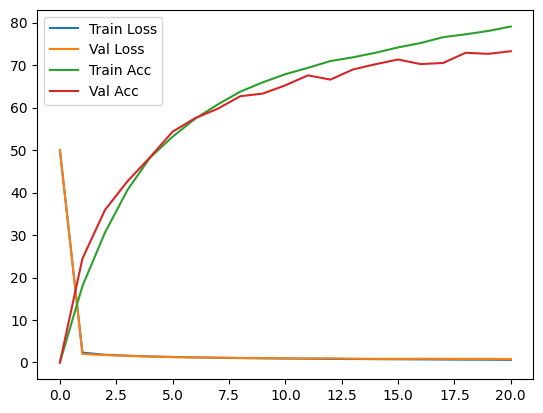

In [7]:
plt.plot(training_loss, label='Train Loss')
plt.plot(validation_loss,label='Val Loss')
plt.plot(training_accuracy, label='Train Acc')
plt.plot(validation_accuracy,label='Val Acc')
plt.legend()
plt.show()

# **Quantitative assessment**

In [8]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')


correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
model.eval()
val_loss = 0
correct_val = 0
total_val = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images.to(device))
        loss = loss_func(outputs, labels.to(device))
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        for label, prediction in zip(labels, predicted.cpu()):
          if label == prediction:
              correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Class accuracy: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'No class accuracy: {classname:5s}')

Accuracy of the network on the test images: 73 %
Class accuracy: plane is 77.6 %
Class accuracy: car   is 88.4 %
Class accuracy: bird  is 69.1 %
Class accuracy: cat   is 42.8 %
Class accuracy: deer  is 79.8 %
Class accuracy: dog   is 49.5 %
Class accuracy: frog  is 81.5 %
Class accuracy: horse is 80.0 %
Class accuracy: ship  is 84.8 %
Class accuracy: truck is 79.1 %
